
**Install requirements**

In [44]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.4.2'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

**Import libraries**

In [0]:
import os
import logging
import itertools
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 7      # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 5e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 20      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
ALPHA = 3e-2

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

**Prepare Dataset**

In [57]:
# Clone github repository with data
if not os.path.isdir('./Homework3-PACS'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS.git

PHOTO_DIR = 'Homework3-PACS/PACS/photo'
ART_DIR = 'Homework3-PACS/PACS/art_painting'
CARTOON_DIR = 'Homework3-PACS/PACS/cartoon'
SKETCH_DIR = 'Homework3-PACS/PACS/sketch'

# Prepare Pytorch train/test Datasets
photo_dataset = torchvision.datasets.ImageFolder(PHOTO_DIR, transform=train_transform)
art_dataset = torchvision.datasets.ImageFolder(ART_DIR, transform=eval_transform)
cartoon_dataset = torchvision.datasets.ImageFolder(CARTOON_DIR, transform=eval_transform)
sketch_dataset = torchvision.datasets.ImageFolder(SKETCH_DIR, transform=eval_transform)

# Check dataset sizes
print('Photo Dataset: {}'.format(len(photo_dataset)))
print('Art Dataset: {}'.format(len(art_dataset)))
print('Cartoon Dataset: {}'.format(len(cartoon_dataset)))
print('Sketch Dataset: {}'.format(len(sketch_dataset)))

Photo Dataset: 1670
Art Dataset: 2048
Cartoon Dataset: 2344
Sketch Dataset: 3929


**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
photo_dataloader = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
art_dataloader = DataLoader(art_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
cartoon_dataloader = DataLoader(cartoon_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
sketch_dataloader = DataLoader(sketch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

**AlexNet with Domain Adaptation**

In [0]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url
from torch.autograd import Function


__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

class ReverseLayerF(Function):
    # Forwards identity
    # Sends backward reversed gradients
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None


class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        self.dann_classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x, alpha=None):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        if alpha is not None:
            # gradient reversal layer (backward gradients will be reversed)
            reverse_feature = ReverseLayerF.apply(x, alpha)
            discriminator_output = self.dann_classifier(reverse_feature)
            return discriminator_output
        # If we don't pass alpha, we assume we are training with supervision
        else:
            classifier_output = self.classifier(x)
            return classifier_output


def alexnet(pretrained=False, progress=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict, strict=False)
        
        model.dann_classifier[1].weight.data = model.classifier[1].weight.data
        model.dann_classifier[1].bias.data = model.classifier[1].bias.data
        model.dann_classifier[4].weight.data = model.classifier[4].weight.data
        model.dann_classifier[4].bias.data = model.classifier[4].bias.data
        model.dann_classifier[6].weight.data = model.classifier[6].weight.data
        model.dann_classifier[6].bias.data = model.classifier[6].bias.data
        
    return model

**Prepare Network**

In [0]:
def prepare_net():
    net = alexnet(pretrained=True) # Loading AlexNet model
    
    # AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
    # We need 7 outputs for PACS
    net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
    # We need 2 outputs for Domains
    net.dann_classifier[6] = nn.Linear(4096, 2)
    
    return net

**Utility Function**

In [0]:
def plot_loss_accuracy_trend(loss_values, accuracy_values):
    
  plt.figure(figsize=(15,5))
  
  plt.subplot(1, 2, 1)
  
  epochs = np.arange(1, NUM_EPOCHS+1)

  if loss_values[2] == None:
    plt.plot(epochs, loss_values[0], label="Training")
    plt.plot(epochs, loss_values[1], label="Validation")
  else:
    plt.plot(epochs, loss_values[0], label="Loss classifier")
    plt.plot(epochs, loss_values[1], label="Loss discriminator (source)")
    plt.plot(epochs, loss_values[2], label="Loss discriminator (target)")

  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Loss")
  plt.grid(True)
  plt.legend()
  
  plt.subplot(1, 2, 2)

  plt.plot(epochs, accuracy_values[0], label="Training")
  plt.plot(epochs, accuracy_values[1], label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Accuracy")
  plt.grid(True)
  plt.legend()

  plt.tight_layout()
  plt.show()

def get_accuracy(model, dataLoader):
  net = model.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in dataLoader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate and return Accuracy
  return running_corrects / float(len(dataLoader.dataset))

**Prepare Training**

In [0]:
def prepare_train():
    # Define loss function
    criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

    # Choose parameters to optimize
    # To access a different set of parameters, you have to access submodules of AlexNet
    # (nn.Module objects, like AlexNet, implement the Composite Pattern)
    # e.g.: parameters of the fully connected layers: net.classifier.parameters()
    # e.g.: parameters of the convolutional layers: net.features.parameters() 
    parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

    # Define optimizer
    # An optimizer updates the weights based on loss
    # We use SGD with momentum
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

    # Define scheduler
    # A scheduler dynamically changes learning rate
    # The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

    return criterion, optimizer, scheduler

**Training functions**

In [0]:
def train(net, train_dataloader, val_dataloader=art_dataloader):
    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

    cudnn.benchmark # Calling this optimizes runtime

    best_net = None
    best_accuracy = 0.0

    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    current_step = 0
    # Start iterating over the epochs
    for epoch in range(NUM_EPOCHS):
      print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))
  
      running_loss = 0.0 
      # Iterate over the dataset
      for images, labels in train_dataloader:
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        net.train() # Sets module in training mode

        optimizer.zero_grad() # Zero-ing the gradients
        
        # Forward pass to the network
        outputs = net(images)
        # Compute loss based on output and ground truth
        loss = criterion(outputs, labels)
        running_loss += loss.item() 

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
          print('Step {}, Loss {}'.format(current_step, loss.item()))
        
        # Compute gradients for each layer and update weights
        loss.backward()  # backward pass: computes gradients
        optimizer.step() # update weights based on accumulated gradients

        current_step += 1
      
      train_loss.append(running_loss/len(train_dataloader))  # compute average loss
      train_acc.append(get_accuracy(net, train_dataloader)) # compute accuracy on train set

      # Evaluate the model on the validation set
      net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
      net.train(False) # Set Network to evaluation mode
            
      running_loss = 0.0  
      running_corrects = 0
      for images, labels in val_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = net(images)
        
        # Compute loss based on output and ground truth
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
        # Get predictions
        _, preds = torch.max(outputs.data, 1)

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

      # Calculate Accuracy
      accuracy = running_corrects / float(len(val_dataloader.dataset))

      print('Test Accuracy on Validation: {}'.format(accuracy))
      
      # Update the best model
      if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_net = copy.deepcopy(net)
      
      val_acc.append(accuracy)
      val_loss.append(running_loss/len(val_dataloader))
            
      # Step the scheduler
      scheduler.step() 

    # Plot loss and accuracy trend
    plot_loss_accuracy_trend([train_loss, val_loss, None], [train_acc, val_acc])
    
    return best_net, best_accuracy


def train_dann(net, source_dataloader, target_dataloader):
    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

    cudnn.benchmark # Calling this optimizes runtime

    best_net = None
    best_accuracy = 0.0

    train_acc = []
    val_acc = []
    train_loss = []
    train_loss0 = []
    train_loss1 = []
    val_loss = []

    current_step = 0
    # Start iterating over the epochs
    for epoch in range(NUM_EPOCHS):
      print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))
      
      running_loss = 0.0 
      running_loss0 = 0.0 
      running_loss1 = 0.0 
      # Iterate over the dataset
      for i, (source_data, target_data) in enumerate(zip(source_dataloader, target_dataloader)):  
        source_images, source_labels = source_data  
        target_images, _ = target_data 
        
        # Bring data over the device of choice
        source_images = source_images.to(DEVICE)
        source_labels = source_labels.to(DEVICE)
        target_images = target_images.to(DEVICE)

        net.train() # Sets module in training mode

        optimizer.zero_grad() # Zero-ing the gradients

        # Forward pass to the network
        outputs = net(source_images)
        # Compute loss based on output and ground truth
        loss = criterion(outputs, source_labels)
        running_loss += loss.item() 
        # Compute gradients for each layer and update weights
        loss.backward()  # backward pass: computes gradients

        # Forward pass to the network
        outputs = net(source_images, alpha=ALPHA)
        targets = torch.zeros(source_labels.size(0), dtype=torch.int64).to(DEVICE)
        # Compute loss based on output and ground truth
        discr_loss0 = criterion(outputs, targets)
        running_loss0 += discr_loss0.item() 
        # Compute gradients for each layer and update weights
        discr_loss0.backward()  # backward pass: computes gradients

        # Forward pass to the network
        outputs = net(target_images, alpha=ALPHA)
        targets = torch.ones(source_labels.size(0), dtype=torch.int64).to(DEVICE)
        # Compute loss based on output and ground truth
        discr_loss1 = criterion(outputs, targets)
        running_loss1 += discr_loss1.item() 
        # Compute gradients for each layer and update weights
        discr_loss1.backward()  # backward pass: computes gradients

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
          print('Step {}, Loss {}'.format(current_step, loss.item()))
          print('Step {}, Discr_Loss0 {}'.format(current_step, discr_loss0.item()))
          print('Step {}, Discr_Loss1 {}'.format(current_step, discr_loss1.item()))
        
        optimizer.step() # update weights based on accumulated gradients
        
        current_step += 1
      
      len_dataloader = min(len(source_dataloader), len(target_dataloader))
      train_loss.append(running_loss/len_dataloader)  # compute average loss
      train_loss0.append(running_loss0/len_dataloader)  # compute average loss
      train_loss1.append(running_loss1/len_dataloader)  # compute average loss
      train_acc.append(get_accuracy(net, source_dataloader)) # compute accuracy on train set
      

      # Evaluate the model on the validation set
      net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
      net.train(False) # Set Network to evaluation mode
            
      running_loss = 0.0  
      running_corrects = 0
      for images, labels in target_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = net(images)
        
        # Compute loss based on output and ground truth
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
        # Get predictions
        _, preds = torch.max(outputs.data, 1)

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

      # Calculate Accuracy
      accuracy = running_corrects / float(len(target_dataloader.dataset))

      print('Test Accuracy on Validation: {}'.format(accuracy))
      
      # Update the best model
      if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_net = copy.deepcopy(net)
      
      val_acc.append(accuracy)
      val_loss.append(running_loss/len(target_dataloader))


      # Step the scheduler
      scheduler.step() 


    # Plot loss and accuracy trend
    plot_loss_accuracy_trend([train_loss, train_loss0, train_loss1], [train_acc, val_acc])
    
    return best_net, best_accuracy

**Test function**

In [0]:
def test(net, test_dataloader):
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in tqdm(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(art_dataset))
  
  return accuracy

**Main**

Starting epoch 1/20, LR = [0.005]
Step 0, Loss 2.348292827606201
Step 0, Discr_Loss0 1.2917776107788086
Step 0, Discr_Loss1 0.4774324595928192
Test Accuracy on Validation: 0.45361328125
Starting epoch 2/20, LR = [0.005]
Step 10, Loss 0.0992569550871849
Step 10, Discr_Loss0 0.19273227453231812
Step 10, Discr_Loss1 0.2265956699848175
Test Accuracy on Validation: 0.46875
Starting epoch 3/20, LR = [0.005]
Test Accuracy on Validation: 0.4697265625
Starting epoch 4/20, LR = [0.005]
Step 20, Loss 0.09644267708063126
Step 20, Discr_Loss0 0.24127832055091858
Step 20, Discr_Loss1 0.0759207233786583
Test Accuracy on Validation: 0.50634765625
Starting epoch 5/20, LR = [0.005]
Test Accuracy on Validation: 0.53173828125
Starting epoch 6/20, LR = [0.005]
Step 30, Loss 0.035607703030109406
Step 30, Discr_Loss0 0.07436894625425339
Step 30, Discr_Loss1 0.148408904671669
Test Accuracy on Validation: 0.50439453125
Starting epoch 7/20, LR = [0.005]
Step 40, Loss 0.009503103792667389
Step 40, Discr_Loss0 0.

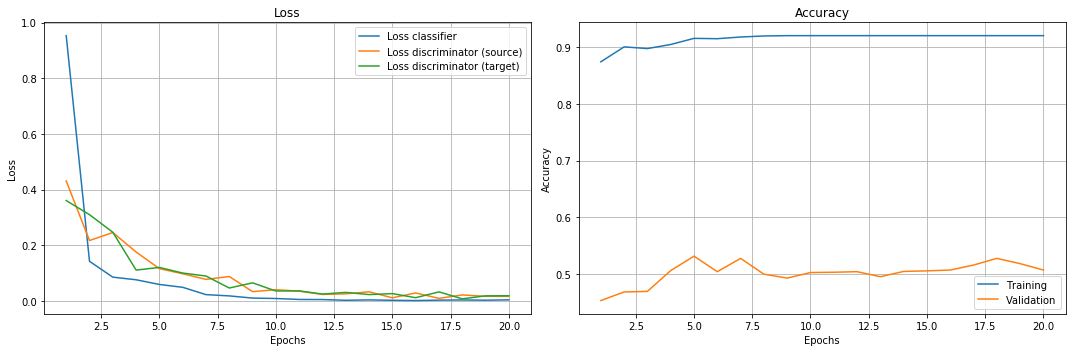

100%|██████████| 8/8 [00:05<00:00,  1.59it/s]


Test Accuracy: 0.53173828125


In [60]:
DOMAIN_ADAPTATION = True  
VALIDATION = False

net = None

if not DOMAIN_ADAPTATION and not VALIDATION:
    net = prepare_net()
    criterion, optimizer, scheduler = prepare_train()
    # Train without domain adaptation on Photo
    net, _ = train(net, photo_dataloader)

elif DOMAIN_ADAPTATION and not VALIDATION:
    net = prepare_net()
    criterion, optimizer, scheduler = prepare_train()
    # Train with domain adaptation on Photo to Art
    net, _ = train_dann(net, photo_dataloader, art_dataloader)

elif not DOMAIN_ADAPTATION and VALIDATION:
    # Train without domain adaptation on Photo to Cartoon and on Photo to Sketch and perform grid search
    LR_set = [5e-3, 1e-3, 1e-4]
    BS_set = [128, 256]
    
    hyperparams_sets=[]
    accuracies1 = []
    accuracies2 = []

    for i, hyperparams in enumerate(itertools.product(LR_set, BS_set)):
      LR, BATCH_SIZE = hyperparams
      
      net = prepare_net()
      criterion, optimizer, scheduler = prepare_train()
      print('(Photo to Catoon) trying with: LR={}, BS={}'.format(LR, BATCH_SIZE))
      # Train without domain adaptation on Photo to Cartoon
      _, accuracy = train(net, photo_dataloader, cartoon_dataloader)
      
      # Save hyperparameter set and accuracy of the net
      hyperparams_sets.append(hyperparams)
      accuracies1.append(accuracy)

      net = prepare_net()
      criterion, optimizer, scheduler = prepare_train()
      print('(Photo to Sketch) trying with: LR={}, BS={}'.format(LR, BATCH_SIZE))
      # Train without domain adaptation on Photo to Sketch
      _, accuracy = train(net, photo_dataloader, sketch_dataloader)
      
      # Save accuracy of the net
      accuracies2.append(accuracy)

    # Compute average of accuracies
    avg_accuracies = (np.array(accuracies1) + np.array(accuracies2)) / 2.0

    # Get the set of hyperparameter with the highest average accuracy
    LR, BATCH_SIZE = hyperparams_sets[list(avg_accuracies).index(np.array(avg_accuracies).max())]
    print('\n**Best hyperparamiters: LR={}, BS={}**\n'.format(LR, BATCH_SIZE))

    net = prepare_net()
    criterion, optimizer, scheduler = prepare_train()
    # Train a new net with the best hyperparamiters found
    net, _ = train(net, photo_dataloader)


elif DOMAIN_ADAPTATION and VALIDATION:
    # Train with domain adaptation on photo to cartoon and on photo to sketch and perform grid search
    LR_set = [5e-3, 1e-3, 1e-4]
    BS_set = [128, 256]
    ALPHA_set = [0.03, 0.01, 0.001]
    
    hyperparams_sets=[]
    accuracies1 = []
    accuracies2 = []

    for i, hyperparams in enumerate(itertools.product(LR_set, BS_set, ALPHA_set)):
      LR, BATCH_SIZE, ALPHA = hyperparams
      
      net = prepare_net()
      criterion, optimizer, scheduler = prepare_train()
      print('(Photo to Catoon) trying with: LR={}, BS={}, ALPHA={}'.format(LR, BATCH_SIZE, ALPHA))
      # Train with domain adaptation on Photo to Cartoon
      _, accuracy = train_dann(net, photo_dataloader, cartoon_dataloader)
      
      # Save hyperparameter set and accuracy of the net
      hyperparams_sets.append(hyperparams)
      accuracies1.append(accuracy)

      net = prepare_net()
      criterion, optimizer, scheduler = prepare_train()
      print('(Photo to Sketch) trying with: LR={}, BS={}, ALPHA={}'.format(LR, BATCH_SIZE, ALPHA))
      # Train with domain adaptation on Photo to Sketch
      _, accuracy = train_dann(net, photo_dataloader, sketch_dataloader)
      
      # Save accuracy of the net
      accuracies2.append(accuracy)

    # Compute average of accuracies
    avg_accuracies = (np.array(accuracies1) + np.array(accuracies2)) / 2.0
        
    # Get the set of hyperparameter with the highest average accuracy    
    LR, BATCH_SIZE, ALPHA = hyperparams_sets[list(avg_accuracies).index(np.array(avg_accuracies).max())]
    print('\n**Best hyperparamiters: LR={}, BS={}, ALPHA={}**\n'.format(LR, BATCH_SIZE, ALPHA))

    net = prepare_net()
    criterion, optimizer, scheduler = prepare_train()
    # Train a new net with the best hyperparamiters found
    net, _ = train_dann(net, photo_dataloader, art_dataloader)

# Test on art
accuracy = test(net, art_dataloader)
print('Test Accuracy: {}'.format(accuracy))